<a href="https://colab.research.google.com/github/DhruvMakwana/Global-Wheat-Detection/blob/master/Global_Wheat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Wheat Detection

## Problem Overview:

Open up your pantry and you’re likely to find several wheat products. Indeed, your morning toast or cereal may rely upon this common grain. Its popularity as a food and crop makes wheat widely studied. To get large and accurate data about wheat fields worldwide, plant scientists use image detection of "wheat heads"—spikes atop the plant containing grain. These images are used to estimate the density and size of wheat heads in different varieties. Farmers can use the data to assess health and maturity when making management decisions in their fields.

However, accurate wheat head detection in outdoor field images can be visually challenging. There is often overlap of dense wheat plants, and the wind can blur the photographs. Both make it difficult to identify single heads. Additionally, appearances vary due to maturity, color, genotype, and head orientation. Finally, because wheat is grown worldwide, different varieties, planting densities, patterns, and field conditions must be considered. Models developed for wheat phenotyping need to generalize between different growing environments. Current detection methods involve one- and two-stage detectors (Yolo-V3 and Faster-RCNN), but even when trained with a large dataset, a bias to the training region remains.

[The Global Wheat Head Dataset](http://www.global-wheat.com/2020-challenge/) is led by nine research institutes from seven countries: the University of Tokyo, Institut national de recherche pour l’agriculture, l’alimentation et l’environnement, Arvalis, ETHZ, University of Saskatchewan, University of Queensland, Nanjing Agricultural University, and Rothamsted Research. These institutions are joined by many in their pursuit of accurate wheat head detection, including the Global Institute for Food Security, DigitAg, Kubota, and Hiphen.

In this competition, you’ll detect wheat heads from outdoor images of wheat plants, including wheat datasets from around the globe. Using worldwide data, you will focus on a generalized solution to estimate the number and size of wheat heads. To better gauge the performance for unseen genotypes, environments, and observational conditions, the training dataset covers multiple regions. You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China.

Wheat is a staple across the globe, which is why this competition must account for different growing conditions. Models developed for wheat phenotyping need to be able to generalize between environments. If successful, researchers can accurately estimate the density and size of wheat heads in different varieties. With improved detection farmers can better assess their crops, ultimately bringing cereal, toast, and other favorite dishes to your table.

## Data:
More details on the data acquisition and processes are available at https://arxiv.org/abs/2005.02162

<b>Data Format:</b>
The data is images of wheat fields, with bounding boxes for each identified wheat head. Not all images include wheat heads / bounding boxes. The images were recorded in many locations around the world.

The CSV data is simple - the image ID matches up with the filename of a given image, and the width and height of the image are included, along with a bounding box. There is a row in train.csv for each bounding box. Not all images have bounding boxes.

<b>Goal:</b> The goal is to predict bounding boxes around each wheat head in images that have them. If there are no wheat heads, you must predict no bounding boxes.

<b>File Structure:</b>
1. train.csv - the training data
2. sample_submission.csv - a sample submission file in the correct format
3. train.zip - training images
4. test.zip - test images

<b>Fields in csv:</b>
1. image_id - the unique image ID
2. width, height - the width and height of the images
3. bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height].

## Step 1: Exploratory Data Analysis:

In [0]:
# importing libraries
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
import cv2
import albumentations as albu

In [0]:
# setup directory and files
base_dir = "/content/drive/My Drive/Dataset"
train_dir = os.path.join(base_dir, 'Train/')
test_dir = os.path.join(base_dir, 'Test/')
train_dataframe = os.path.join(base_dir, 'train.csv')

In [57]:
# number of images in train and test
print("Number of Training images are: {}".format(len(glob(train_dir + '*'))))
print("Number of Testing images are: {}".format(len(glob(test_dir + '*'))))

Number of Training images are: 3422
Number of Testing images are: 10


As mentioned in problem overview we have only 10 testing images and other images are hidden which will be used at submission.

We are having 3422 images for training which is not enough. So we need to augment our data to increase performance.

We will cover Augmentation in step **Replace this with step number**.

Its mentioned in problem overview that not all images are having bouding box. so lets check how many of the images are not having bounding box.

In [58]:
# load dataframe
df = pd.read_csv(train_dataframe)
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [0]:
# create dataframe with all training images
training_images_dataframe = pd.DataFrame([fns.split('/')[-1][:-4] for fns in glob(train_dir + '*')])
training_images_dataframe.columns=['image_id']

# merge it with bboxes dataframe
training_images_dataframe = training_images_dataframe.merge(df, on='image_id', how='left')

# replace null values with list of 0
training_images_dataframe['bbox'] = training_images_dataframe.bbox.fillna('[0,0,0,0]')

# split bboxes column
bbox_items = training_images_dataframe.bbox.str.split(',', expand=True)
training_images_dataframe['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
training_images_dataframe['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
training_images_dataframe['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
training_images_dataframe['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [60]:
training_images_dataframe.head()

image_id   width  height  ... bbox_ymin bbox_width  bbox_height
0  229d8a499  1024.0  1024.0  ...     449.0       77.0         62.0
1  229d8a499  1024.0  1024.0  ...     423.0      117.0         95.0
2  229d8a499  1024.0  1024.0  ...     535.0       87.0         97.0
3  229d8a499  1024.0  1024.0  ...     586.0       79.0         83.0
4  229d8a499  1024.0  1024.0  ...     337.0       69.0         98.0

[5 rows x 9 columns]

In [61]:
print('Number of images without heads are: {}'.format(len(training_images_dataframe) - len(df)))

Number of images without heads are: 49


In [0]:
def get_all_bboxes(df, image_id):
  image_bboxes = df[df.image_id == image_id]
  
  bboxes = []
  for _, row in image_bboxes.iterrows():
    bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
  
  return bboxes

In [0]:
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
  fig, axs = plt.subplots(rows, cols, figsize=(10,10))
  for row in range(rows):
    for col in range(cols):
      idx = np.random.randint(len(df), size=1)[0]
      img_id = df.iloc[idx].image_id
      
      img = Image.open(train_dir + img_id + '.jpg')
      axs[row, col].imshow(img)
      
      bboxes = get_all_bboxes(df, img_id)
      
      for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[row, col].add_patch(rect)
        
        axs[row, col].axis('off')    
  plt.suptitle(title)

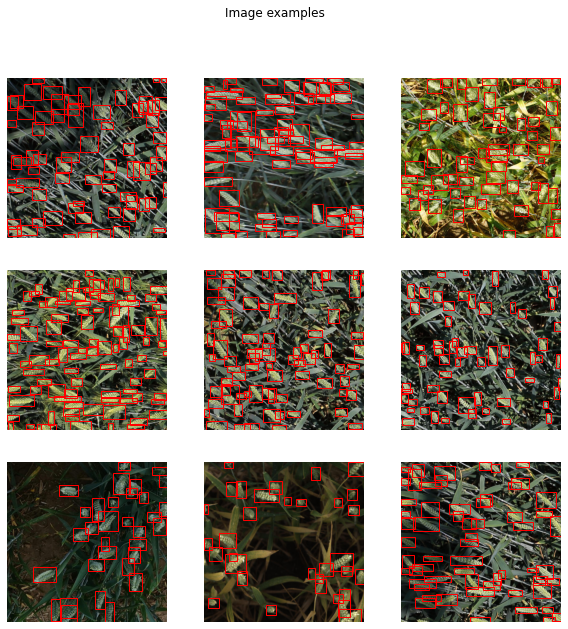

In [64]:
plot_image_examples(training_images_dataframe)

In [0]:
# number of bouding boxes per train image
training_images_dataframe['count'] = training_images_dataframe.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
training_images_count = training_images_dataframe.groupby('image_id').sum().reset_index()

In [66]:
training_images_count.head()

image_id    width   height  ...  bbox_width  bbox_height  count
0  00333207f  56320.0  56320.0  ...      4792.0       3846.0     55
1  005b0d8bb  20480.0  20480.0  ...      2739.0       2410.0     20
2  006a994f7  25600.0  25600.0  ...      2856.0       2835.0     25
3  00764ad5d  41984.0  41984.0  ...      3951.0       3361.0     41
4  00b5c6764      0.0      0.0  ...         0.0          0.0      0

[5 rows x 8 columns]

In [0]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
  hist, edges = np.histogram(dataframe[column], bins = bins)
  
  hist_df = pd.DataFrame({column: hist, 
                          "left": edges[:-1],
                          "right": edges[1:]})
  hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                         right in zip(hist_df["left"], hist_df["right"])]
                         
  src = ColumnDataSource(hist_df)
  plot = figure(plot_height = 400, plot_width = 600,
                title = title,
                x_axis_label = column,
                y_axis_label = "Count")    
  plot.quad(bottom = 0, top = column,left = "left", 
            right = "right", source = src, fill_color = colors[0], 
            line_color = "#35838d", fill_alpha = 0.7,
            hover_fill_alpha = 0.7, hover_fill_color = colors[1])
  
  hover = HoverTool(tooltips = [('Interval', '@interval'), ('Count', str("@" + column))])
  plot.add_tools(hover)
  
  output_notebook()
  show(plot)

In [68]:
hist_hover(training_images_count, 'count', title='Number of wheat spikes per image')

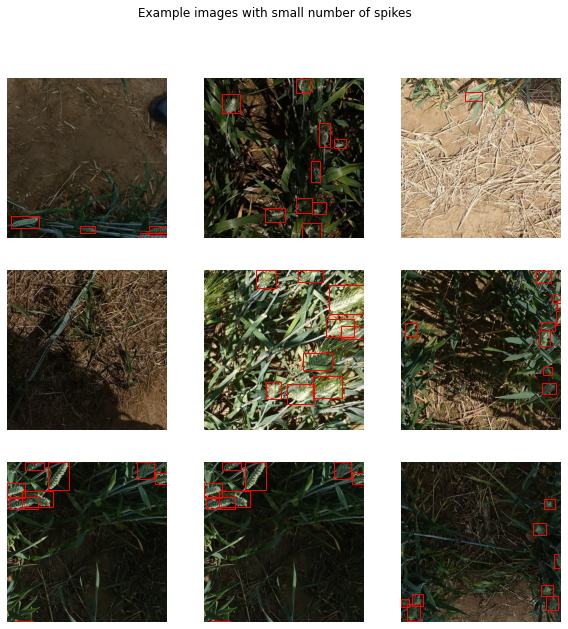

In [69]:
# Images with less spikes
less_spikes_ids = training_images_count[training_images_count['count'] < 10].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')

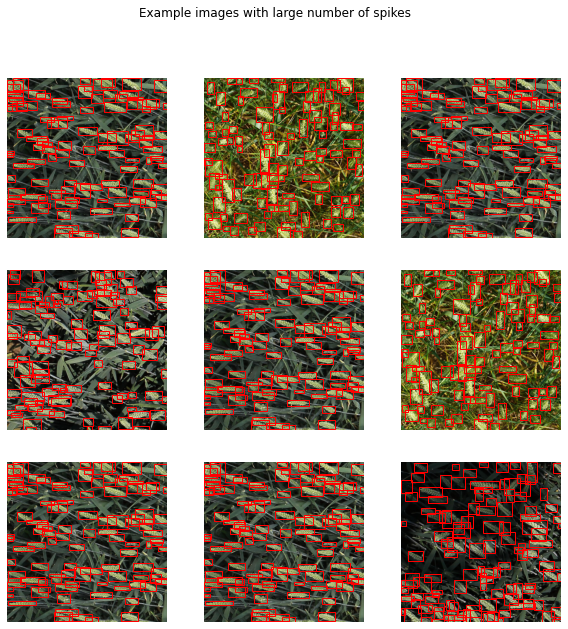

In [70]:
# Images with more spikes
many_spikes_ids = training_images_count[training_images_count['count'] > 100].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(many_spikes_ids)], title='Example images with large number of spikes')

In [0]:
# areas of bboxes
training_images_dataframe['bbox_area'] = training_images_dataframe['bbox_width'] * training_images_dataframe['bbox_height']

In [72]:
hist_hover(training_images_dataframe, 'bbox_area', title="Area of a single bounding box")

In [73]:
training_images_dataframe.bbox_area.max()

529788.0

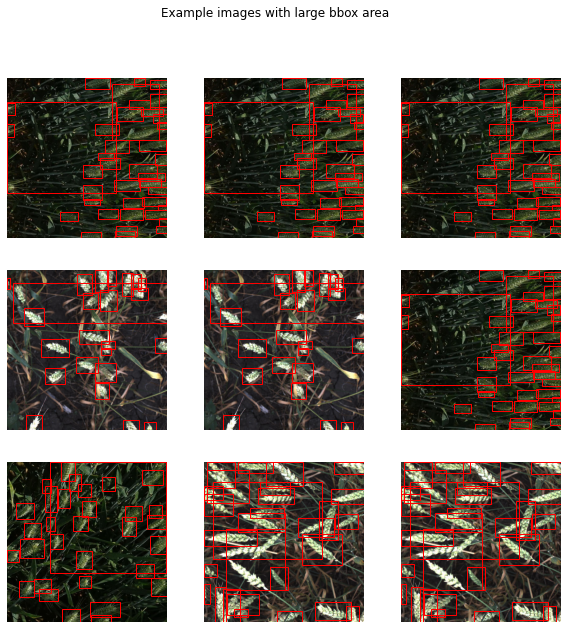

In [74]:
large_boxes_ids = training_images_dataframe[training_images_dataframe['bbox_area'] > 200000].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')

In [75]:
min_area = training_images_dataframe[training_images_dataframe['bbox_area'] > 0].bbox_area.min()
print('The smallest bouding box area is {}'.format(min_area))

The smallest bouding box area is 2.0


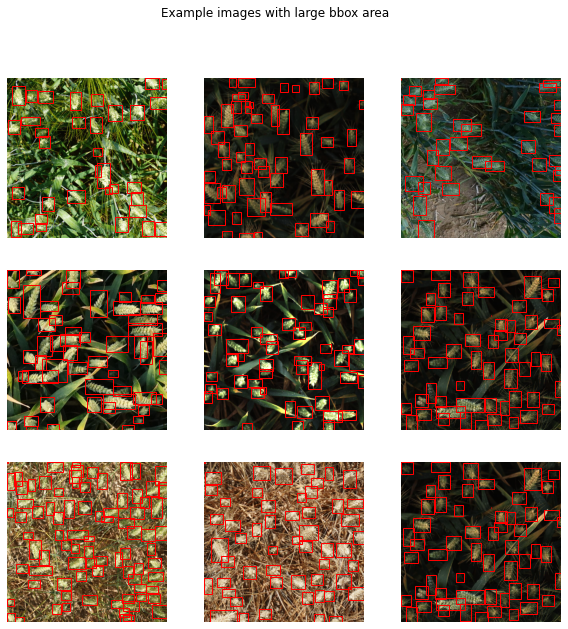

In [76]:
small_boxes_ids = training_images_dataframe[(training_images_dataframe['bbox_area'] < 25) & (training_images_dataframe['bbox_area'] > 0)].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(small_boxes_ids)], title='Example images with large bbox area')

In [0]:
# compute the total bounding boxes area per image
area_per_image = training_images_dataframe.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100

In [78]:
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

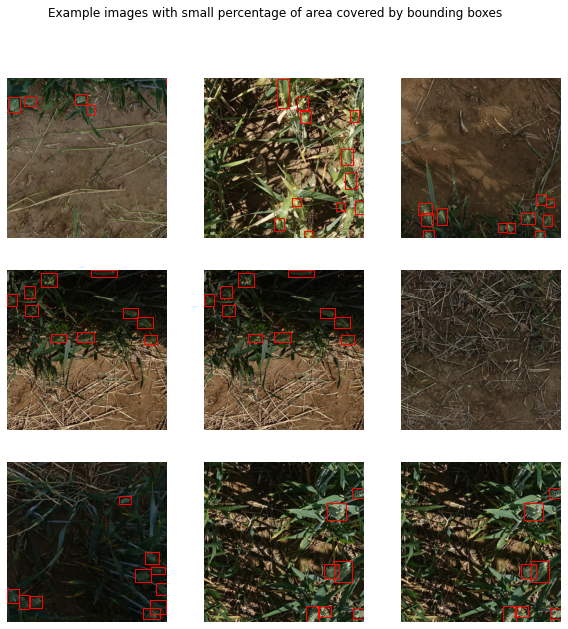

In [79]:
small_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] < 7].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(small_area_perc_ids)], title='Example images with small percentage of area covered by bounding boxes')

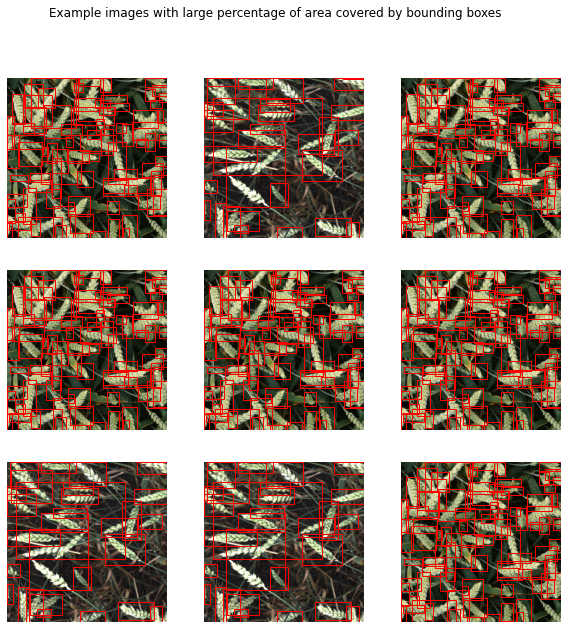

In [80]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 95].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')

In [0]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(train_dir + img_id + '.jpg')
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [0]:
images_df = pd.DataFrame(training_images_dataframe.image_id.unique())
images_df.columns = ['image_id']

In [0]:
# add brightness to the dataframe
images_df = pd.DataFrame(training_images_dataframe.image_id.unique())
images_df.columns = ['image_id']
brightness_df = add_brightness(images_df)

training_images_dataframe = training_images_dataframe.merge(brightness_df, on='image_id')

In [84]:
hist_hover(training_images_dataframe, 'brightness', title='Images brightness distribution')

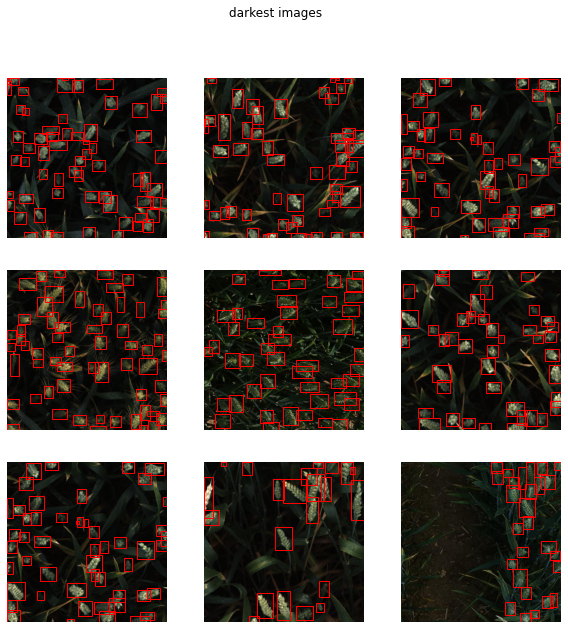

In [85]:
# darkest images
dark_ids = training_images_dataframe[training_images_dataframe['brightness'] < 30].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(dark_ids)], title="darkest images")

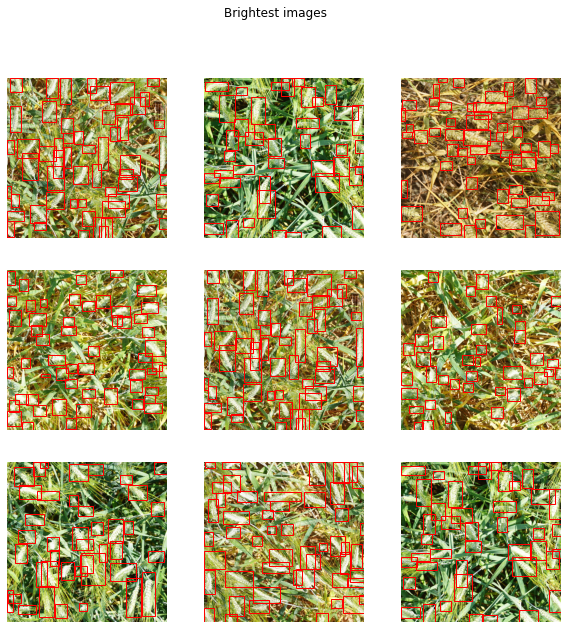

In [86]:
# Brightest images
bright_ids = training_images_dataframe[training_images_dataframe['brightness'] > 130].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(bright_ids)], title='Brightest images')

In [0]:
def get_percentage_of_green_pixels(image):
  # convert to HSV
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  
  # get the green mask
  hsv_lower = (40, 40, 40) 
  hsv_higher = (70, 255, 255)
  green_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
  
  return float(np.sum(green_mask)) / 255 / (1024 * 1024)

In [0]:
def get_percentage_of_yellow_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (25, 40, 40) 
    hsv_higher = (35, 255, 255)
    yellow_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(yellow_mask)) / 255 / (1024 * 1024)

In [0]:
def add_green_pixels_percentage(df):
    green = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(train_dir + img_id + '.jpg')
        green.append(get_percentage_of_green_pixels(image))
        
    green_df = pd.DataFrame(green)
    green_df.columns = ['green_pixels']
    df = pd.concat([df, green_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'green_pixels']
    
    return df

In [0]:
def add_yellow_pixels_percentage(df):
    yellow = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(train_dir + img_id + '.jpg')
        yellow.append(get_percentage_of_yellow_pixels(image))
        
    yellow_df = pd.DataFrame(yellow)
    yellow_df.columns = ['yellow_pixels']
    df = pd.concat([df, yellow_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'yellow_pixels']
    
    return df

In [0]:
# add a column with the percentage of green pixels
green_pixels_df = add_green_pixels_percentage(images_df)
training_images_dataframe = training_images_dataframe.merge(green_pixels_df, on='image_id')

In [92]:
hist_hover(training_images_dataframe, 'green_pixels', title='Percentage of green pixels distribution', colors=['#c3ea84', '#3e7a17'])

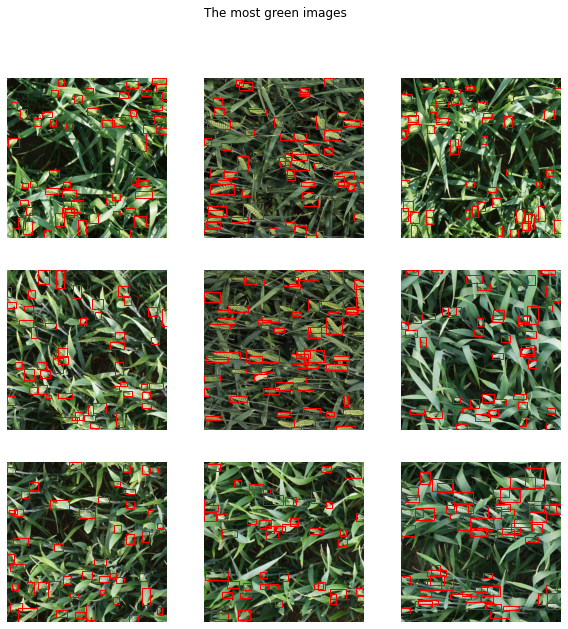

In [93]:
green_ids = training_images_dataframe[training_images_dataframe['green_pixels'] > 0.55].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(green_ids)], title='The most green images')

In [0]:
# add a column with the percentage of yellow pixels
yellow_pixels_df = add_yellow_pixels_percentage(images_df)
training_images_dataframe = training_images_dataframe.merge(yellow_pixels_df, on='image_id')

In [95]:
hist_hover(training_images_dataframe, 'yellow_pixels', title='Percentage of yellow pixels distribution', colors=['#fffedb', '#fffeab'])

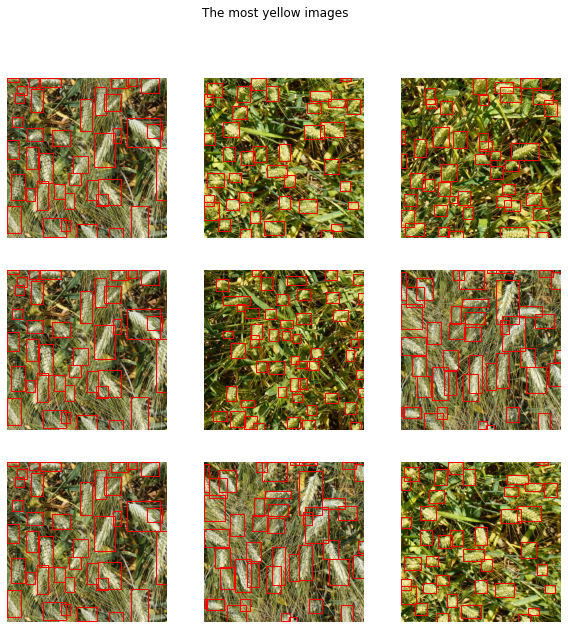

In [96]:
yellow_ids = training_images_dataframe[training_images_dataframe['yellow_pixels'] > 0.55].image_id
plot_image_examples(training_images_dataframe[training_images_dataframe.image_id.isin(yellow_ids)], title='The most yellow images')

In [0]:
example_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=1.0),
    albu.CLAHE(p=1.0)], p=1.0)

In [0]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    image = Image.open(train_dir + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

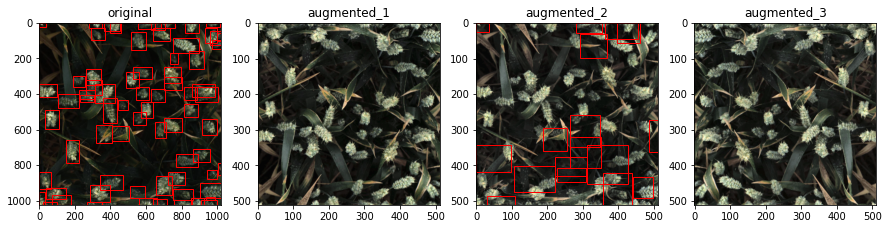

In [101]:
apply_transforms(example_transforms, training_images_dataframe, n_transforms=3)

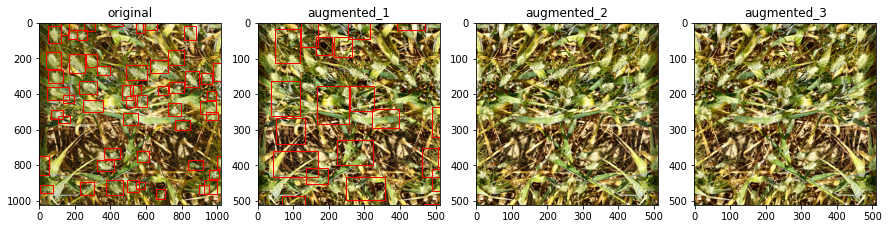

In [102]:
apply_transforms(example_transforms, training_images_dataframe, n_transforms=3)